In [1]:
!pip install split-folders

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
print(tf.__version__)

2.6.2


In [6]:
data_dir = '../input/braintumor/Datasets(2)/Training'
batch_size=16
image_size=224

In [7]:
splitfolders.ratio(data_dir, output='datsets1', ratio=(0.8, 0.1003, 0.0997))

Copying files: 1019 files [00:03, 277.85 files/s]


In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/datsets1/train/',
  image_size=(image_size, image_size),
  shuffle = True,
  seed=123,
  batch_size=16
)

Found 815 files belonging to 2 classes.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/datsets1/val/',
  label_mode ='int',
  image_size=(image_size, image_size),
  shuffle = False,
  batch_size=16)

Found 102 files belonging to 2 classes.


In [18]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/datsets1/test/',
  label_mode ='int',
  image_size=(image_size, image_size),
  shuffle = False,
  batch_size=16
)

Found 102 files belonging to 2 classes.


In [19]:
class_names = test_ds.class_names
print(class_names)

['no_tumor', 'tumor']


In [20]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [21]:
normalization_layer1 = tf.keras.layers.Rescaling(1./255)
normalization_layer2 = tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], 
                      variance=[np.square(0.5), 
                                np.square(0.5), 
                                np.square(0.5)])

2022-05-09 23:30:16.169111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


-0.9867 0.9931


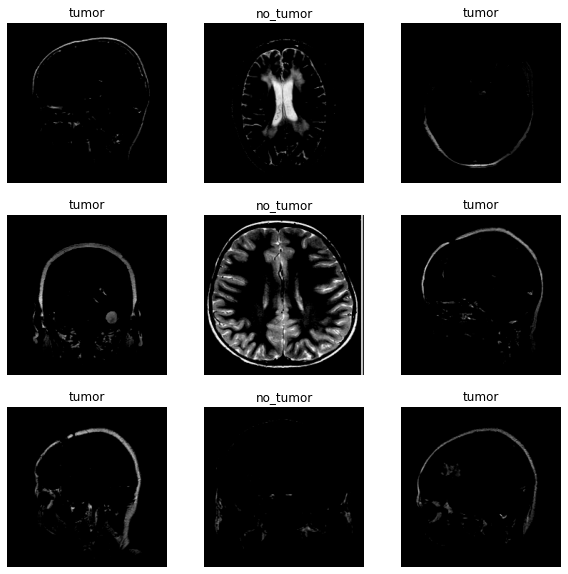

In [22]:
train_ds_normalized = train_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in train_ds_normalized:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

-0.9867 0.9931


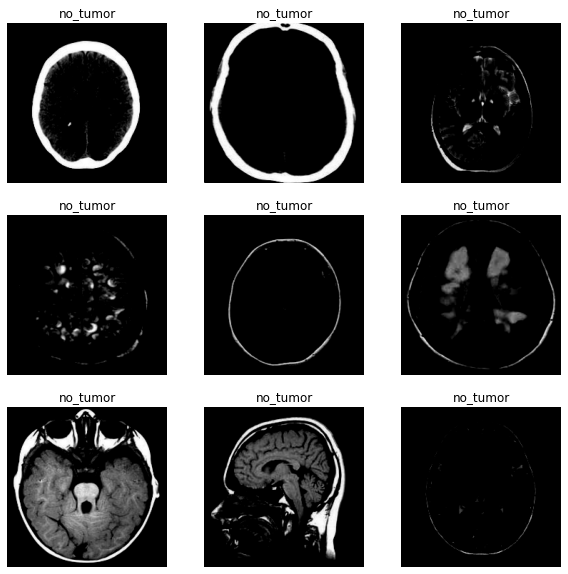

In [27]:
val_ds_normalized = val_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(val_ds_normalized))

print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in val_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

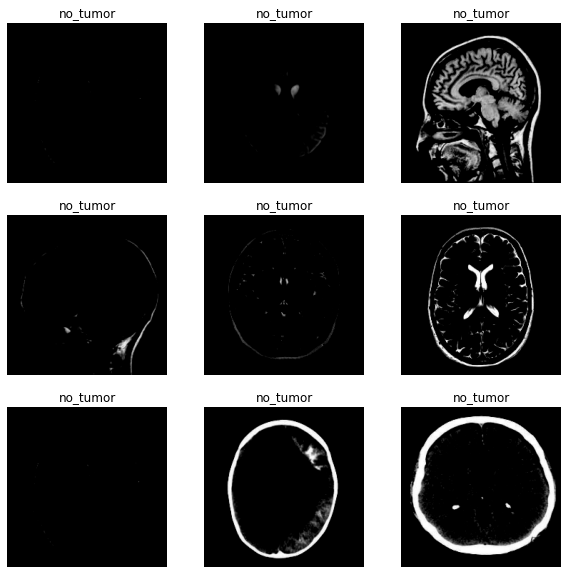

In [28]:
test_ds_normalized = test_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(test_ds_normalized))
plt.figure(figsize=(10, 10))
for images, labels in test_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
y_test = [label for images, labels in test_ds_normalized for label in labels.numpy()]

In [30]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Tensorflow and Keras')
   
    y_prediction = np.argmax(y_pred,axis=1)
    report = classification_report(y_test, y_prediction, target_names=class_names)
    print(f'{report}')

    fig, ax = plt.subplots(figsize=(7,7)) 
    ax.set_title(f'Confusion Matrix {model} Tensorflow and Keras')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)

In [31]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                  "id": 1,
                  "variables":['accuracy', 'val_accuracy'],
                  "labels":['Training Accuracy', 'Validation Accuracy'],
                  "legend":'lower right',
                  "title":f'Accuracy Tensorflow and Keras - {model}',
                  "ylabel":'Accuracy'
              },{ 
                  "id": 2,
                  "variables":['loss', 'val_loss'],
                  "labels":['Training Loss', 'Validation Loss'],
                  "legend":'upper right',
                  "title":f'Loss Tensorflow and Keras - {model}',
                  "ylabel":'Loss'
              }]
    epochs_range = range(25)
    for tab in tab_plot: 
          plt.subplot(1, 2, tab['id'])
          plt.plot(epochs_range, history.history[tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
          plt.plot(epochs_range, history.history[tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
          plt.legend(loc=tab['legend'])
          plt.title(tab['title'])
          plt.xlabel('Epochs')
          plt.ylabel(tab['ylabel'])
    plt.show()

In [36]:
from tensorflow.keras.applications import MobileNetV2 #EfficientNetB0 
model =  MobileNetV2(weights=None,include_top=True,input_shape=(image_size,image_size,3),alpha=1, classifier_activation='softmax',classes=2)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [38]:
print('Train Mobilenetv2 Tensorflow and Keras')
history_mobilenet_v2 = model.fit(train_ds_normalized,  validation_data=(val_ds_normalized), epochs=5)

Train Mobilenetv2 Tensorflow and Keras
Epoch 1/5
51/51 [==============================] - 50s 894ms/step - loss: 0.5934 - accuracy: 0.7129 - val_loss: 0.6930 - val_accuracy: 0.5098
Epoch 2/5
51/51 [==============================] - 44s 855ms/step - loss: 0.4916 - accuracy: 0.8123 - val_loss: 0.6966 - val_accuracy: 0.5098
Epoch 3/5
51/51 [==============================] - 43s 846ms/step - loss: 0.3374 - accuracy: 0.8724 - val_loss: 0.7083 - val_accuracy: 0.5098
Epoch 4/5
51/51 [==============================] - 44s 852ms/step - loss: 0.2459 - accuracy: 0.9055 - val_loss: 0.7495 - val_accuracy: 0.5098
Epoch 5/5
51/51 [==============================] - 43s 846ms/step - loss: 0.2576 - accuracy: 0.8933 - val_loss: 0.7422 - val_accuracy: 0.5098


In [44]:
from tensorflow.keras.applications import DenseNet121 #EfficientNetB0 
model_densenet = DenseNet121(weights=None,include_top=True,input_shape=(image_size,image_size,3),classes=2)

In [46]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [47]:
print('Train DenseNet121 Tensorflow and Keras')
history_densenet = model_densenet.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=5)

Train DenseNet121 Tensorflow and Keras
Epoch 1/5
51/51 [==============================] - 191s 4s/step - loss: 0.5937 - accuracy: 0.7644 - val_loss: 1.5247 - val_accuracy: 0.4510
Epoch 2/5
51/51 [==============================] - 181s 4s/step - loss: 0.4087 - accuracy: 0.8356 - val_loss: 1.5655 - val_accuracy: 0.4510
Epoch 3/5
51/51 [==============================] - 180s 4s/step - loss: 0.3564 - accuracy: 0.8626 - val_loss: 1.1280 - val_accuracy: 0.5686
Epoch 4/5
51/51 [==============================] - 180s 4s/step - loss: 0.3693 - accuracy: 0.8552 - val_loss: 0.4901 - val_accuracy: 0.7941
Epoch 5/5
51/51 [==============================] - 175s 3s/step - loss: 0.3698 - accuracy: 0.8663 - val_loss: 0.4663 - val_accuracy: 0.7843


In [52]:
from tensorflow.keras.applications import ResNet50 #EfficientNetB0 
model_resnet50 =  ResNet50(weights=None,include_top=True,input_shape=(image_size,image_size,3), classifier_activation='softmax',classes=2)

In [53]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [54]:
print('Train Resnet50 Tensorflow and Keras')
history_resnet50 = model_resnet50.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=5)

Train Resnet50 Tensorflow and Keras
Epoch 1/5
51/51 [==============================] - 191s 4s/step - loss: 1.1790 - accuracy: 0.7190 - val_loss: 1.3674 - val_accuracy: 0.4902
Epoch 2/5
51/51 [==============================] - 189s 4s/step - loss: 0.4713 - accuracy: 0.8123 - val_loss: 1.6981 - val_accuracy: 0.4902
Epoch 3/5
51/51 [==============================] - 187s 4s/step - loss: 0.3999 - accuracy: 0.8442 - val_loss: 5.1857 - val_accuracy: 0.4902
Epoch 4/5
51/51 [==============================] - 189s 4s/step - loss: 0.4871 - accuracy: 0.8233 - val_loss: 3.1670 - val_accuracy: 0.4216
Epoch 5/5
51/51 [==============================] - 189s 4s/step - loss: 0.4074 - accuracy: 0.8417 - val_loss: 7.5158 - val_accuracy: 0.5686
